In [36]:
import os
import tqdm
import warnings
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

import plotly.graph_objects as go
import plotly.express as px

from sklearn.linear_model import LinearRegression

from shapely.geometry import Point
import matplotlib.font_manager as fm 
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

from xlrd import open_workbook
from collections import defaultdict

# 전체 데이터 요약
[전체 데이터 요약](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/5942da61-46cd-4833-bdb3-e4cc9647fc6f..png)

## 1. 시청 시작 데이터 : history_data.csv
[시청 시작 데이터](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/2b762359-78b9-470c-9369-5d1b3d9ff06f..png)

In [4]:
df_history = pd.read_csv('data/history_data.csv', index_col=False).drop_duplicates(ignore_index=True)

df_history

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N
...,...,...,...,...,...,...,...,...
899268,33032,20220427155091,20220427155668,MKID003,381,NaN,Y,N
899269,33032,20220427155091,20220427155680,MKID003,381,NaN,Y,N
899270,33032,20220427155839,20220427155810,MKID003,125,NaN,Y,N
899271,33032,20220427155706,20220427155838,MKID003,125,NaN,Y,N


### profile_id

In [5]:
# 결측값 확인

df_history_col = df_history.columns
df_nan = pd.DataFrame(index=['Null', 'Null percentage'], columns=df_history_col)

for c_name in df_history_col:
    df_nan[c_name] = [list(df_history[c_name].isnull()).count(True), 
                    "%.2f%%" % (list(df_history[c_name].isnull()).count(True)*100/len(df_history))]

df_nan

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
Null,0,0,0,0,0,840080,0,0
Null percentage,0.00%,0.00%,0.00%,0.00%,0.00%,93.42%,0.00%,0.00%


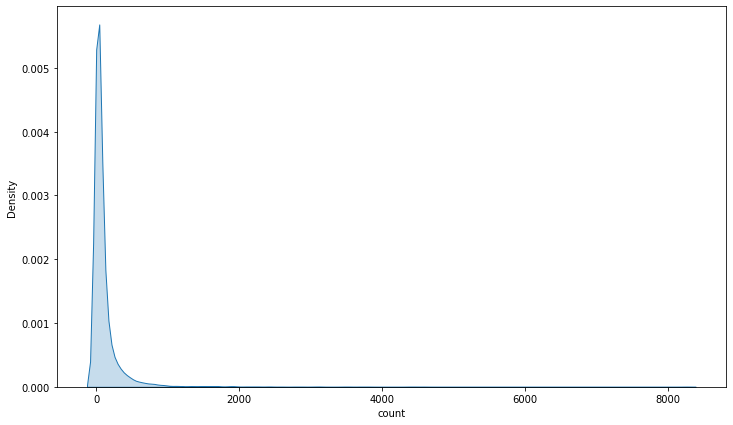

In [6]:
# 기록된 프로필 고유 ID 값 : 총 8311개

g = df_history['profile_id'].groupby(df_history['profile_id']).count() # ID 당 시청 시작 이력 확인

g = g.reset_index(name='count')

fig, ax = plt.subplots(figsize=(12, 7))

sns.kdeplot(x='count', data=g, ax=ax, fill=True)

plt.show()


### ss_id, log_time

In [7]:
ss_id = df_history['ss_id'].unique()
log_time = df_history['log_time'].unique()

print('ss_id length:', len(ss_id))
print('log_time length:', len(log_time))

# Session 저장 시간의 간격의 기준 찾아야 할 듯 -> 2nd file에서 확인

ss_id length: 117749
log_time length: 797725


### payment

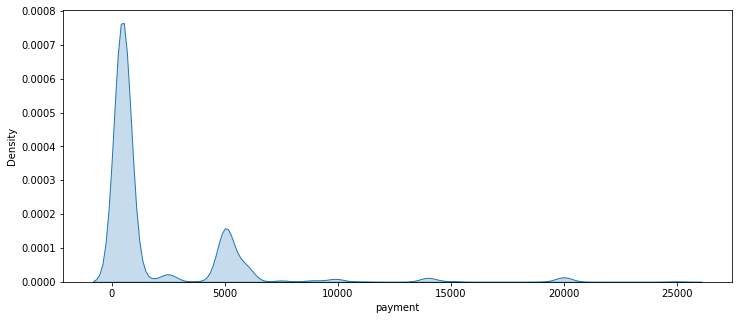

In [8]:
# 지불한 금액 범위 확인
df_history_payment = df_history[df_history['payment'].notnull()]
fig, ax = plt.subplots(1,1, figsize=(12, 5))

sns.kdeplot(x='payment', data=df_history_payment, ax=ax, fill=True)

plt.show()

### continuous_play

In [9]:
df_history_continuous_type = df_history['continuous_play'].unique()

df_history_continuous_type_count = []

for type_ in df_history_continuous_type:
    df_history_continuous_type_count.append(
        list(df_history['continuous_play'] == type_).count(True))
    

for i in range(len(df_history_continuous_type)):
    print(df_history_continuous_type[i], ':', df_history_continuous_type_count[i])



Y : 811869
N : 87404


### short_trailer

In [10]:
df_history_trailer = df_history['short_trailer'].unique()

df_history_trailer_count = []

for type_ in df_history_trailer:
    df_history_trailer_count.append(
        list(df_history['short_trailer'] == type_).count(True))
    

#for i in range(len(df_history_trailer)):
#    print(df_history_trailer[i], ':', df_history_trailer_count[i])

# album ID 와의 연관성

idx = (df_history['short_trailer'] == 'Y')

df_history_album_y = df_history[df_history['short_trailer'] == 'Y']['album_id'].unique()

for id in df_history_album_y:
    idx = (df_history['album_id'] == id)
    print(df_history[idx]['short_trailer'].describe())
    break

# album ID와 short trailer는 1의 상관관계가 있는 것은 아님


count     1062
unique       2
top          Y
freq       956
Name: short_trailer, dtype: object


## 2. 시청 종료 데이터 : watch_e_data.csv
[시청 종료 데이터](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/81a5741f-9481-49ed-8533-1e62d5f9fb50..png)

In [11]:
df_watch = pd.read_csv('data/watch_e_data.csv', index_col=False).drop_duplicates(ignore_index=True)

In [18]:
# 결측값 확인

df_watch_col = df_watch.columns
df_nan = pd.DataFrame(index=['Null', 'Null percentage'], columns=df_watch_col)

for c_name in df_watch_col:
    df_nan[c_name] = [list(df_watch[c_name].isnull()).count(True), 
                    "%.2f%%" % (list(df_watch[c_name].isnull()).count(True)*100/len(df_watch))]

df_nan

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,watch_ratio
Null,0,0,0,0,0,0,0,0,0
Null percentage,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [12]:
idx_history = (df_history['profile_id'] == 5950) & (df_history['ss_id'] == 20220416202406) & (df_history['log_time'] == 20220416210631)

print(df_history[idx_history])     

idx = (df_watch['profile_id'] == 5950) & (df_watch['ss_id'] == 20220416202406)

df_watch[idx]

        profile_id           ss_id        log_time act_target_dtl  album_id  \
228815        5950  20220416202406  20220416210631        MKID003      4869   

        payment continuous_play short_trailer  
228815      NaN               Y             N  


,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
204878,5950,20220416202406,20220416205337,MKID049,4869,715,715,1
204879,5950,20220416202406,20220416205354,MKID049,11025,15,702,1
204880,5950,20220416202406,20220416205401,MKID049,11025,5,702,0
204881,5950,20220416202406,20220416205441,MKID049,4869,31,715,0
204882,5950,20220416202406,20220416205545,MKID049,4869,18,715,0
204883,5950,20220416202406,20220416205643,MKID049,4869,30,715,0
204884,5950,20220416202406,20220416205726,MKID049,4869,33,715,0
204885,5950,20220416202406,20220416205806,MKID049,4869,32,715,0
204886,5950,20220416202406,20220416205845,MKID049,4869,31,715,0
204887,5950,20220416202406,20220416210336,MKID049,4869,265,715,1


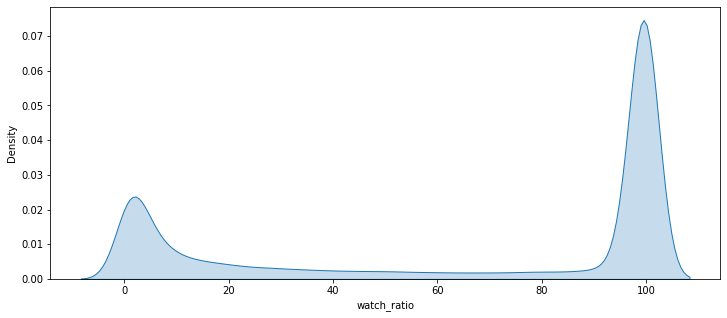

In [16]:
df_watch['watch_ratio'] = (df_watch['watch_time']*100) / df_watch['total_time']

fig, ax = plt.subplots(1,1, figsize=(12, 5))

sns.kdeplot(x='watch_ratio', data=df_watch, ax=ax, fill=True)

plt.show()

count    800740.000000
mean        184.764108
std         219.358891
min           0.000000
25%          32.000000
50%          99.000000
75%         298.000000
max        4769.000000
Name: watch_time, dtype: float64


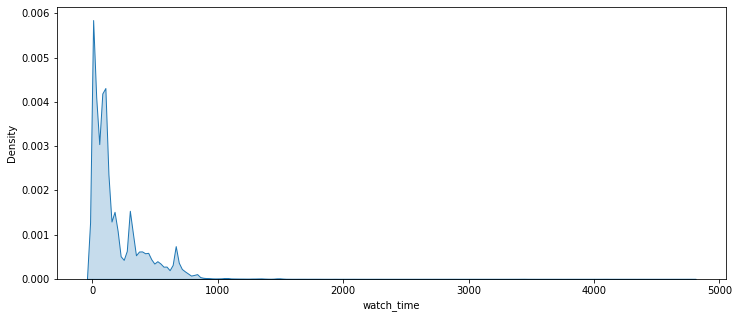

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))

sns.kdeplot(x='watch_time', data=df_watch, ax=ax, fill=True)

print(df_watch['watch_time'].describe())

plt.show()

### continuous_play

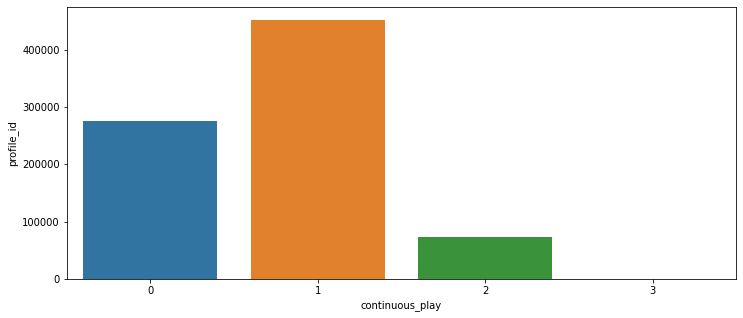

In [27]:
# 0: 이후 컨텐츠 재생 없음, 1: 연속재생, 2: 선택에 의한 종료, 3: 기타 종료

fig, ax = plt.subplots(1,1, figsize=(12, 5))

g = df_watch.groupby('continuous_play')['profile_id'].count()
g = g.reset_index()

sns.barplot(x=g['continuous_play'], y=g['profile_id'])

plt.show()


In [30]:
# 시청시간 비율에 따른 각 선택지의 상관관계 분석

df_watch.groupby('continuous_play')['watch_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
continuous_play,,,,,,,,
0,274882.0,37.788383,38.627477,0.0,2.682927,20.305541,78.281034,100.000000
1,451794.0,88.621332,27.908631,0.0,98.404255,99.697428,100.000000,100.000000
2,73897.0,23.601549,29.791382,0.0,1.923077,8.450704,36.082474,100.000000
3,167.0,8.657518,21.170086,0.0,0.000000,0.726392,3.939206,97.560976


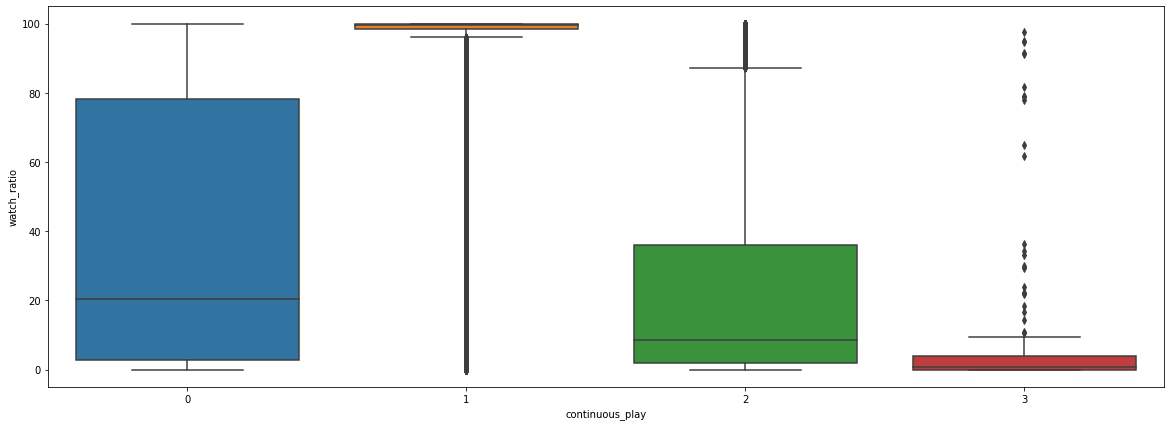

In [43]:
fig, ax = plt.subplots(1,1, figsize=(20, 7))

sns.boxplot(y='watch_ratio', x='continuous_play', data=df_watch)

plt.show()

## 3. 구매 이력 데이터 : buy_data.csv

In [45]:
df_buy = pd.read_csv('data/watch_e_data.csv', index_col=False).drop_duplicates(ignore_index=True)

df_buy

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,20220301115653,20220301115805,MKID049,15,46,46,1
1,3,20220301115653,20220301115954,MKID049,16,104,105,1
2,3,20220301115653,20220301120114,MKID049,17,76,76,1
3,3,20220301115653,20220301120226,MKID049,18,67,68,1
4,3,20220301115653,20220301120400,MKID049,19,90,90,0
...,...,...,...,...,...,...,...,...
800735,33032,20220427155091,20220427155653,MKID049,381,463,464,1
800736,33032,20220427155091,20220427155694,MKID049,381,462,463,1
800737,33032,20220427155839,20220427155826,MKID049,125,10,520,0
800738,33032,20220427155706,20220427155836,MKID049,125,6,521,0
